# CLASSIFICATION OF CONTACTS IN PROTEIN STRUCTURE
### A project by Antonio Feltrin, Emma Lovato and Mattia Piazza

## Introduction
Residue Interaction Networks (RINs) are derived from protein structures based on geometrical and physico-chemical properties of amino acids. 

RING is a software tool that takes a PDB file as input and returns the list of contacts (residue-residue pairs) and their types in a protein structure.

The contact types include: 
- Hydrogen bonds (HBOND)
- Van der Waals interactions (VDW)
- Disulfide bridges (SSBOND)
- Salt bridges (IONIC)
- π-π stacking (PIPISTACK)
- π-cation (PICATION)
- π-hydrogen bond (PIHBOND)

## Goal
The goal of this project is to develop a software tool that predicts the RING classification of a contact based on statistical or supervised learning methods, rather than geometrical constraints. This report details the implementation and results of our approach.

## Methods
We implemented a learning approach to classify contacts in protein structures. The implementation includes features extraction, diverse models training, and evaluation.

## Importing Libraries


In [78]:
# basics/util
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import random
import joblib
import logging
import itertools

# sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    RandomizedSearchCV,
    HalvingRandomSearchCV,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    matthews_corrcoef,
    balanced_accuracy_score,
)
from scipy.stats import uniform
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer


# plot
import seaborn as sns
import matplotlib.pyplot as plt

# PCA
from sklearn.decomposition import PCA

# NNet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    InputLayer,
    Embedding,
    Flatten,
    Input,
    Concatenate,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# HiddenLayer
import hiddenlayer as hl

## Pre-Processing
We build a large dataframe from the RING analyses of 3299 proteins. We drop the rows containing NaN values (mainly, the 'Interaction' = 'Unclassified' records) and filter out some of the features. 

Each row identifies a contact, with the same 12 features for the source and target residues. The last column is the RING prediction.
 
resn and ss8 are categorical features, the other are numerical.

|feature| meaning|
|-------|:------|
| resn   |residue name|   
| ss8    |secondary structure state(DSSP)    |
| rsa    |relative solvent accessibility|
| up     |half sphere exposure up|
| down   |half sphere exposure down|
| phi    |phi angle|
| psi    |psi angle|
| a1     |Atchley feature 1|
| a2     |Atchley feature 2|
| a3     |Atchley feature 3|
| a4     |Atchley feature 4|
| a5     |Atchley feature 5|

In [79]:
random.seed(42)

In [80]:
path_to_data = Path("../data")

df = pd.read_csv(path_to_data / "df.csv")

# Remove all rows with NaN in at least one column
# including rows with missing class (they could be false negatives)
print(f"Shape of complete dataset: {df.shape}")

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Shape of complete dataset: {df.shape}")

df.head()

Shape of complete dataset: (2468259, 35)
Shape of complete dataset: (1228807, 35)


,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,dist,Interaction
0,1aba,A,50,,E,H,0.304,7.0,10.0,-1.107,...,-1.102,-0.657,H,1.831,-0.561,0.533,-0.277,1.648,6.292980,HBOND
1,1aba,A,67,,Q,E,0.086,14.0,24.0,-2.214,...,-1.350,2.242,H,0.336,-0.417,-1.673,-1.474,-0.078,7.907008,HBOND
2,1aba,A,17,,C,H,0.000,17.0,17.0,-1.093,...,-1.043,-0.817,H,1.831,-0.561,0.533,-0.277,1.648,6.614870,HBOND
3,1aba,A,45,,D,H,0.742,1.0,13.0,-1.182,...,-1.034,-0.718,H,-0.591,-1.302,-0.733,1.570,-0.146,6.087462,HBOND
4,1aba,A,39,,E,B,0.634,0.0,15.0,-2.661,...,-2.073,2.008,H,-1.337,-0.279,-0.544,1.242,-1.262,5.471278,HBOND


In [81]:
# Define ground truth values
y = df["Interaction"].astype("category")
print(f"Our target y: \n\n{y.head()}\n")

# Define training features
X = df.drop("Interaction", axis=1)

print("Rest of the feature:")
X.head()

Our target y: 

0    HBOND
1    HBOND
2    HBOND
3    HBOND
4    HBOND
Name: Interaction, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

Rest of the feature:


,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,dist
0,1aba,A,50,,E,H,0.304,7.0,10.0,-1.107,...,6.0,-1.102,-0.657,H,1.831,-0.561,0.533,-0.277,1.648,6.292980
1,1aba,A,67,,Q,E,0.086,14.0,24.0,-2.214,...,16.0,-1.350,2.242,H,0.336,-0.417,-1.673,-1.474,-0.078,7.907008
2,1aba,A,17,,C,H,0.000,17.0,17.0,-1.093,...,23.0,-1.043,-0.817,H,1.831,-0.561,0.533,-0.277,1.648,6.614870
3,1aba,A,45,,D,H,0.742,1.0,13.0,-1.182,...,16.0,-1.034,-0.718,H,-0.591,-1.302,-0.733,1.570,-0.146,6.087462
4,1aba,A,39,,E,B,0.634,0.0,15.0,-2.661,...,12.0,-2.073,2.008,H,-1.337,-0.279,-0.544,1.242,-1.262,5.471278


## Data augumentation
Data augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing data. By applying transformations such as rotation, scaling, cropping, flipping, and adding noise, data augmentation helps models improving accuracy on unseen data.

In [82]:
# Bonds
abundancy_bonds = df.groupby(["Interaction"]).size()
print(f"abundancy_bonds: \n{abundancy_bonds}\n")

rare_abundancy = abundancy_bonds[abundancy_bonds < 100000]
print(f"rare_abundancy: \n{rare_abundancy}\n")

print(f"rarebonds: \n{rare_abundancy.keys()}\n")

abundancy_bonds: 
Interaction
HBOND        686925
IONIC         22654
PICATION       5619
PIHBOND        1333
PIPISTACK     25070
SSBOND         1273
VDW          485933
dtype: int64

rare_abundancy: 
Interaction
IONIC        22654
PICATION      5619
PIHBOND       1333
PIPISTACK    25070
SSBOND        1273
dtype: int64

rarebonds: 
Index(['IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND'], dtype='object', name='Interaction')



In [83]:
# Number of augumented records per class
oversamples = {
    "IONIC": 80000,
    "PICATION": 60000,
    "PIHBOND": 40000,
    "PIPISTACK": 80000,
    "SSBOND": 40000,
}  # see table above

oversamples.values()

dict_values([80000, 60000, 40000, 80000, 40000])

In [84]:
# Lis of columns to modify in data augumentation phase
col_to_mod = [
    "s_rsa",
    "s_up",
    "s_down",
    "s_phi",
    "s_psi",
    "t_rsa",
    "t_up",
    "t_down",
    "t_phi",
    "t_psi",
    "dist",
]
col_to_mod_idx = [
    index for index, value in enumerate(df.columns) if value in col_to_mod
]
col_to_mod_idx  # this is the list of column indexes on which we want to perform DAUG

[6, 7, 8, 9, 10, 22, 23, 24, 25, 26, 33]

In [85]:
# Function to modify some entries of a row
def mod_row(row, factor=0.01, idxs=[], extract=-1, verbose=False):
    # idxs by default are all
    if len(idxs) < 1:
        idxs = np.arange(0, row.shape[0])  # which indexes/columns can be modified?
    if extract < 0:
        extract = np.random.choice(
            len(idxs) + 1, 1
        )  # how many indexes do you want to mod? NB choice(5,1) is btw 0 and 4 included so must do 5+1 to select a 5 (all items in row)

    col_mutated = np.sort(
        np.random.choice(idxs, size=extract, replace=False)
    )  # select randomly which columns to modify

    mrow = row.copy()
    mrow[col_mutated] += np.random.uniform(
        -factor,
        factor,  # we want to modify not more than the `factor` the original value
    )

    if verbose:
        print(f"extract = {extract}\n, col_mutated = {col_mutated}\n, row = {row}")

    return mrow

### Data augumentation workflow

IDEA:
- do for every rare class:

  - create Xdumbo = X where interaction == class

  - create aug_df = []

  - do for every oversample in rare class:

      - take a row, mod it, append it to aug_df

  - append augmented class (aug_df) to the whole dataset

In [86]:
# Reminder
for i in zip(rare_abundancy.index, rare_abundancy, oversamples.values()):
    print(i)

('IONIC', 22654, 80000)
('PICATION', 5619, 60000)
('PIHBOND', 1333, 40000)
('PIPISTACK', 25070, 80000)
('SSBOND', 1273, 40000)


In [87]:
# Split the dataset to define training and testing examples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

y_train_OHE = to_categorical(y_train.cat.codes, num_classes=len(abundancy_bonds))
y_test_OHE = to_categorical(y_test.cat.codes, num_classes=len(abundancy_bonds))

y_test_OHE

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Data augumentation processing

In [96]:
df.iloc[X_train.index]

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,dist,Interaction
243108,2v8t,A,197,,E,H,0.263,13.0,12.0,-1.030,...,-0.998,-0.621,H,-0.663,-1.524,2.219,-1.005,1.212,6.292905,VDW
1174930,8fkl,A,320,,D,-,0.018,23.0,16.0,-1.613,...,-0.993,-0.805,H,1.538,-0.055,1.502,0.440,2.897,11.103512,HBOND
1081841,7qsp,B,71,,D,H,0.503,3.0,25.0,-1.176,...,-1.836,-0.034,H,1.050,0.302,-3.656,-0.259,-3.242,5.395722,HBOND
546951,4i84,B,141,,G,S,0.071,20.0,13.0,-1.706,...,-1.984,2.392,H,1.357,-1.453,1.477,0.113,-0.837,9.088269,HBOND
225620,2psd,A,142,,H,E,0.005,24.0,24.0,-2.457,...,-1.977,2.096,H,-1.006,-0.590,1.891,-0.397,0.412,10.954343,VDW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,1vdw,A,206,,V,H,0.007,19.0,35.0,-1.190,...,-1.067,-0.828,H,1.538,-0.055,1.502,0.440,2.897,11.286278,HBOND
259178,2wol,A,378,,A,H,0.000,22.0,17.0,-1.054,...,-1.002,-0.770,H,-1.019,-0.987,-1.505,1.266,-0.912,10.339930,HBOND
131932,1zhx,A,141,,V,E,0.000,19.0,18.0,-1.505,...,-2.458,2.217,H,-1.337,-0.279,-0.544,1.242,-1.262,13.853061,HBOND
671155,4zr8,A,124,,V,H,0.007,24.0,22.0,-1.220,...,-1.143,-0.821,H,-0.591,-1.302,-0.733,1.570,-0.146,5.299414,HBOND


In [97]:
# Data Augumentation
DAUG = pd.DataFrame([])
DAUG_factor = 1.01  # conservative tweak

for inter in rare_abundancy.index:  # df["Interaction"]:
    print(oversamples[inter], inter, rare_abundancy.loc[inter])

    Xtemp = df.iloc[X_train.index][df["Interaction"] == inter]

    data_aug = pd.DataFrame(np.nan, index=range(oversamples[inter]), columns=df.columns)

    for i in range(oversamples[inter]):
        pp = i % Xtemp.shape[0]  # this way, if 1669 < 10000, we restart
        row = np.array(Xtemp.iloc[pp])  # take a row
        data_aug.iloc[i] = mod_row(
            row, factor=DAUG_factor, idxs=col_to_mod_idx, verbose=False
        )  # mod it

    print(f"{inter} done")
    DAUG = pd.concat([DAUG, data_aug], ignore_index=True)

DAUG.sample(frac=1).reset_index(drop=True, inplace=True)

80000 IONIC 22654


/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Xtemp = df.iloc[X_train.index][df["Interaction"] == inter]
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4h6b' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item 

Done: 0/80000 ~ IONIC
60000 PICATION 5619


/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Xtemp = df.iloc[X_train.index][df["Interaction"] == inter]
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7czj' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item 

Done: 0/60000 ~ PICATION
40000 PIHBOND 1333


/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Xtemp = df.iloc[X_train.index][df["Interaction"] == inter]
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1t6u' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'I' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item 

Done: 0/40000 ~ PIHBOND
80000 PIPISTACK 25070


/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Xtemp = df.iloc[X_train.index][df["Interaction"] == inter]
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8q29' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item 

Done: 0/80000 ~ PIPISTACK
40000 SSBOND 1273


/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Xtemp = df.iloc[X_train.index][df["Interaction"] == inter]
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1ezg' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_aug.iloc[i] = mod_row(
/var/folders/g_/y28yhgf91f9cxp6kdq0vn15r0000gn/T/ipykernel_12639/977443110.py:18: FutureWarning: Setting an item 

Done: 0/40000 ~ SSBOND


In [98]:
# Dataframe
DAUG.shape  # .head()

(300000, 35)

As we can see above, the DAUG takes rows from the original dataframe and tweaks them. Only some specifics columns are untouched. (it would not make any sense, for example, to change the Atchley features or the amino acid species).

In [99]:
# Last check size
print(X_train.shape)
print(DAUG.shape)

(1105926, 34)
(300000, 35)


Finally, the merge with the "mother dataframe".

In [105]:
y_train = pd.concat([y_train, DAUG["Interaction"]], ignore_index=True)


X_train = pd.concat([X_train, DAUG.drop("Interaction", axis=1)], ignore_index=True)
X_train_num = X_train[
    [
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
        "dist",
    ]
]

X_test_num = X_test[
    [
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
        "dist",
    ]
]

## Random Forest
The Random Forest classifier was chosen for its robustness and ability to handle large datasets with high dimensionality.

For classification tasks, it outputs the class that is the mode of the classes output by individual trees. The underlying principle involves two main steps:

- Bootstrap Aggregating (Bagging): Random subsets of the training data are used to train each tree. This helps in reducing the variance of the model without increasing the bias.
- Random Feature Selection: At each split in the tree, a random subset of features is considered, ensuring that the trees are de-correlated.

### Model implementation
We implemented the Random Forest algorithm, a powerful ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes for classification tasks.

We create the model and then the performance of the model is evaluated by calculating the number of mislabeled points and the overall accuracy.


In [106]:
# Train the RF model
y_pred = RandomForestClassifier().fit(X_train_num, y_train).predict(X_test_num)

# Performance of the model
print(f"Number of mislabeled points: {(y_test != y_pred).sum()}/{X_test.shape[0]} ")

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Number of mislabeled points: 65883/122881 
Accuracy: 0.46384713666067173


### Results
The trained Random Forest model is evaluated on the test set. 

The performance metrics indicate the effectiveness of the model. The number of mislabeled points out of the total test points is printed, followed by the accuracy of the model. The accuracy achieved demonstrates the model's capability in classifying the contact types in the protein structures.

## Logistic Regression

### Model training
We trained a Logistic Regression model for multi-class classification. The target variable is the interaction type, and the features are the various structural and physico-chemical properties of the residues involved in the contact.

In [24]:
path_to_data = Path("../data")

df_complete = pd.read_csv(path_to_data / "df_start.csv")
df_complete.dropna(inplace=True)

y = df_complete["Interaction"].astype("category")
# Define training features
X = df_complete[
    [
        "s_ss8",
        "s_ss3",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_ss8",
        "t_ss3",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset to define training and testing examples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [25]:
# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize
        ("logreg", LogisticRegression(random_state=42)),
    ]
)

# Define the hyperparameter grid
param_dist = {
    "logreg__C": uniform(loc=0.1, scale=5),  # Reduce the range of C values
    "logreg__solver": ["liblinear"],
    "logreg__penalty": ["l2"],  # Only one penalty
    "logreg__max_iter": [100],  # Only one value for max_iter
}

# Define the cross-validation strategy:
# Use cross-validation to select the best model hyperparameters.
cv_strategy = StratifiedKFold(
    n_splits=3, shuffle=True, random_state=42
)  # Use fewer folds

# Perform hyperparameter search with HalvingRandomSearchCV
random_search = HalvingRandomSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_candidates=30,  # Limit the number of candidates
    factor=3,
    resource="n_samples",
    max_resources="auto",
    min_resources=50,  # Increase min_resources to start with more samples
    cv=cv_strategy,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

# Fit the model:
# Training the Logistic Regression model on the training dataset.
random_search.fit(X_train, y_train)

# Best model
best_logreg = random_search.best_estimator_

# Results
print(f"\nBest score: {random_search.best_score_}")
print(f"Best parameters: {random_search.best_params_}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 10
min_resources_: 50
max_resources_: 1319465
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 50
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 10
n_resources: 150
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 4
n_resources: 450
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 1350
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.5567202837581458
Best parameters: {'logreg__C': 1.1616955533913809, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


### Evaluation
The model is evaluated using the following metrics to assess the model performance:

- Cross-validation Accuracy: The average accuracy obtained across different splits of the data during cross-validation
- Accuracy: The ratio of correctly predicted instances to the total instances.
- Matthews Correlation Coefficient (MCC): A correlation coefficient between the observed and predicted binary classifications, considering true and false positives and negatives.
- Balanced Accuracy: he average of recall obtained on each class
- ROC-AUC: A metric that measures the area under the ROC curve, which plots the true positive rate against the false positive rate for different threshold values.
- Classification Report: 
    1. Precision: The ratio of true positive predictions to the total predicted positives for each class. It indicates how many of the predicted positive instances are actually correct.
    2. Recall: The ratio of true positive predictions to the total actual positives for each class. It measures how many of the actual positive instances are correctly predicted.
    3. F1-Score: The harmonic mean of precision and recall, providing a balance between the two metrics.
    4. Support: The number of actual occurrences of each class in the test set

In [26]:
# Cross-validation
cv = StratifiedKFold(n_splits=3)
cv_scores = cross_val_score(
    best_logreg, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
)  # Parallelization

print(f"Cross-validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Prediction
y_pred = best_logreg.predict(X_test)

# Evaluation metrichs
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(
    pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class="ovo"
)

print(f"Accuracy: {accuracy:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-validation Accuracy: 0.57 ± 0.00
Accuracy: 0.57
Matthews Correlation Coefficient: 0.09
Balanced Accuracy: 0.25
ROC-AUC: 0.52
Classification Report:


/Users/mattiapiazza/Documents/University/structural_bioinformatics/project/sb_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mattiapiazza/Documents/University/structural_bioinformatics/project/sb_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       HBOND       0.57      0.96      0.72     81732
       IONIC       0.00      0.00      0.00      2743
    PICATION       0.00      0.00      0.00       685
     PIHBOND       0.00      0.00      0.00       167
   PIPISTACK       0.41      0.28      0.33      3002
      SSBOND       0.46      0.47      0.47       165
         VDW       0.45      0.06      0.11     58114

    accuracy                           0.57    146608
   macro avg       0.27      0.25      0.23    146608
weighted avg       0.51      0.57      0.45    146608



/Users/mattiapiazza/Documents/University/structural_bioinformatics/project/sb_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We used then the CONFUSION MATRIX, that is a table used to evaluate the performance of a classification model. It provides a comprehensive insight into how well the model is making predictions by showing the actual versus predicted classifications.

The confusion matrix consists of four components:
- True Positives (TP): The number of instances correctly predicted as positive.
- True Negatives (TN): The number of instances correctly predicted as negative.
- False Positives (FP): The number of instances incorrectly predicted as positive (Type I error).
- False Negatives (FN): The number of instances incorrectly predicted as negative (Type II error).

For multiclass classification, the confusion matrix is an n×n matrix where n is the number of classes. Each cell (i,j) in the matrix represents the number of observations that are actually in class i but predicted to be in class j.


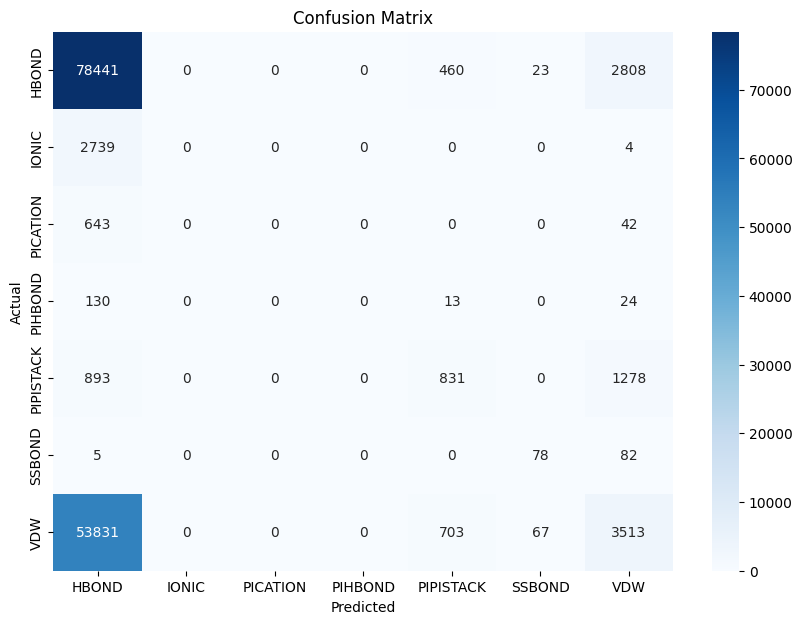

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y),
    yticklabels=np.unique(y),
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a classification model.
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. 

The area under the ROC curve (AUC) provides a single measure of a classifier's performance across all classification thresholds.

Micro-average ROC: Aggregates the contributions of all classes to calculate a single ROC curve. It weights the results based on the frequency of the classes and is influenced by the most frequent class.

Macro-average ROC: Calculates a separate ROC curve for each class and then averages them. It treats each class with equal importance, regardless of their frequency, and weights each class equally.

When to use which?
- Micro-average ROC: when you want an overall measure of your model's performance that takes class distribution into account. It is suitable for datasets with imbalanced classes.
- Macro-average ROC: when you want to evaluate the average performance of your model across all classes without the class distribution affecting the result. It is suitable for datasets with balanced classes or when each class is equally important.

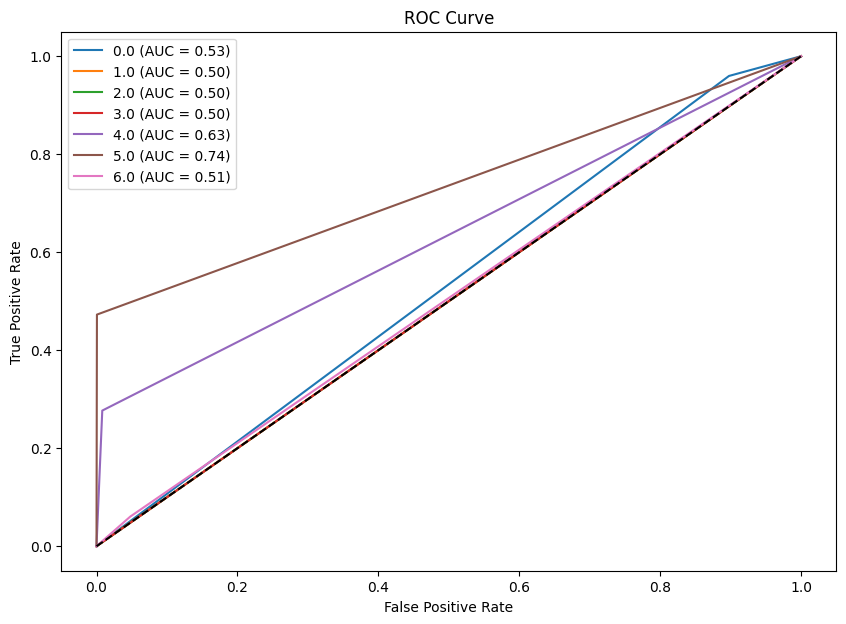

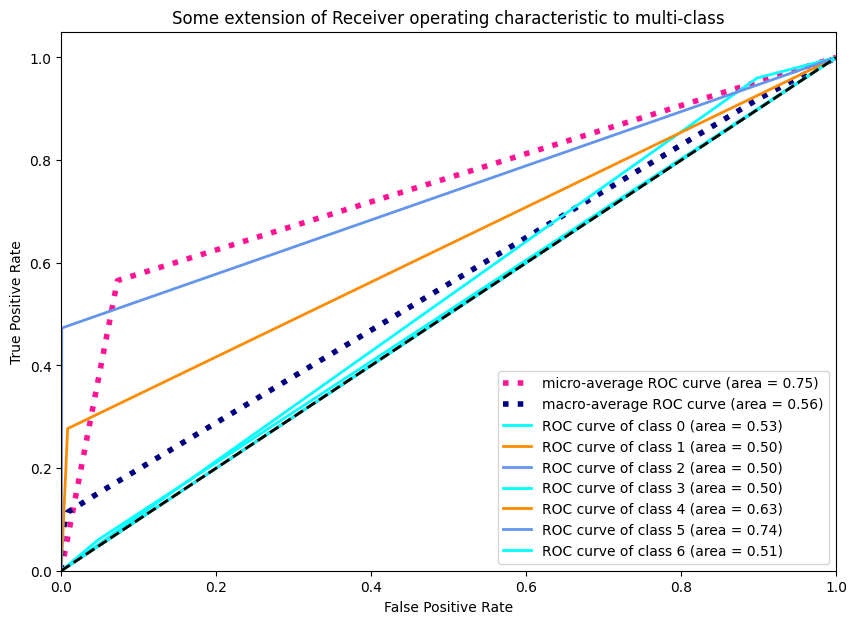

In [31]:
# ROC Curve

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y))

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(yy)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_binarized.ravel(), y_pred_binarized.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})" "".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})" "".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = itertools.cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})" "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multi-class")
plt.legend(loc="lower right")
plt.show()

### Results
- Cross-validation accuracy: It provides an estimate of how the model is expected to perform on unseen data. A value of 0.57 ± 0.00 indicates that the model has a consistent accuracy of 57% across the three folds.
- Accuracy: Accuracy measures how often the model correctly predicts the classes. An accuracy of 0.57 means the model correctly predicts 57% of the instances in the test set.
- MCC: MCC ranges from -1 to 1, where 1 indicates perfect prediction, 0 no better than random prediction, and -1 indicates total disagreement. An MCC of 0.10 suggests a low positive correlation between the predictions and the actual classes.
- Balanced Accuracy: This metric adjusts for imbalanced class distribution by considering the recall of each class. A balanced accuracy of 0.27 indicates poor performance, especially for less frequent classes.
- ROC-AUC: For multiclass classification, it is computed using the one-vs-one (ovo) method. A value of 0.54 indicates that the model's ability to distinguish between classes is only slightly better than random guessing.
- Classification report summary:
    1. HBOND: The model performs reasonably well with a precision of 0.57 and a recall of 0.96.
    2. IONIC, PICATION, PIHBOND: The model struggles with these classes, achieving very low precision and recall, indicating poor prediction capabilities.
    3. PIPISTACK: Shows moderate performance with a precision of 0.41 and a recall of 0.27.
    4. SSBOND: Has a relatively better performance with a precision of 0.54 and a recall of 0.61.
    5. VDW: The model performs poorly with a precision of 0.47 and a recall of 0.07.
    6. Overall Accuracy: The model's overall accuracy is 0.57, indicating that it correctly predicts 57% of the instances.
    7. Macro Average: Averages precision, recall, and F1-score across all classes, treating all classes equally. The macro averages are 0.34 (precision), 0.27 (recall), and 0.25 (F1-score).
    8. Weighted Average: Averages precision, recall, and F1-score across all classes, weighted by the number of instances of each class. The weighted averages are 0.52 (precision), 0.57 (recall), and 0.45 (F1-score).
- Confusion matrix describes that there are:
    1. Class Imbalance: The model shows varying performance across different classes, with the majority classes such as HBOND and VDW having higher accuracy. 
    This suggests that the model might be biased towards these majority classes.
    2. VDW Class: There are significant misclassifications into the VDW class, particularly from HBOND and PIPISTACK. This indicates that the features distinguishing these classes might be similar, leading to confusion in the model.
    3. Minority Classes: Classes like PICATION and PIHBOND have very low correct prediction rates, highlighting the model's difficulty in accurately identifying these less frequent classes.
    4. General Accuracy: While the model performs well for the majority classes, the lower performance for minority classes suggests a need for improved handling of class imbalance, potentially through techniques like oversampling, undersampling, or using different evaluation metrics.
- ROC curve and AUC: 
    1. Class Imbalance: The model handles class imbalance well, as indicated by the high micro-average AUC. This suggests that the overall performance is robust despite varying class frequencies.
    2. High Performance for Major Classes: Classes like HBOND and IONIC show excellent ROC curves with AUC values close to 1.0, indicating high precision and recall for these classes.
    3. Moderate Performance for Minor Classes: Classes such as PIPISTACK and SSBOND exhibit moderate performance. This highlights areas where the model could be improved, particularly in distinguishing these classes from others.
    4. Model Improvement Areas: The moderate AUC for certain classes suggests that the model could benefit from additional tuning or feature engineering to improve its discriminative ability for these specific classes.

## Neural Network

### Introduction to Neural Networks
Artificial Neural Networks (NNs) are computational models inspired by the human brain. They consist of interconnected nodes (neurons) organized in layers: an input layer, one or more hidden layers, and an output layer. Each connection between neurons has an associated weight that is adjusted during training to minimize the error in predictions. Through a process called backpropagation the network learns by updating these weights based on the error rate obtained from the output compared to the actual result. This ability to learn and adapt makes NNs powerful tools also in multiclass classification problem such as this project.

### Structure of the Neural Network
For our project, we implemented a neural network using the TensorFlow/Keras framework. 

The neural network is composed of the following layers:
- Input Layer: Receives the feature values extracted from protein residues.
- Hidden Layers: We used two fully connected hidden layers with ReLU (Rectified Linear Unit) activation functions. The hidden layers allow the network to learn complex representations of the input data.
- Output Layer: A single fully connected layer with a softmax activation function to classify the contacts into one of the predefined categories (e.g., HBOND, VDW, etc.).

### Data pre-processing and preparation for Neural Network
Before training the neural network, we convert the target labels (contact types) into a format suitable for classification tasks. 

The data we possess contains both numerical and categorical features, so it makes sense to encode them in different ways. Every numerical feature will be fed to the neural network as it is, so there will be one input neuron for each of them. Conversely, we want to remark the importance of the categorical variables res_n and ss8, i.e. the residue name and its secondary structure role as provided by DSSP. 

Some types of bonds are exclusive to specific side chains (e.g. all the SSBOND contacts are between Cysteines). We will use one-hot encoding to preserve these properties, if possible.

The OHdata_num function tranforms our 24-features dataset into a 78-features one. This is done by converting the 4 categorical features into their corresponding OH-encoding (20-dimensional for s_resn and t_resn, 9-dimensional for s_ss8 and s_ss8). This dataset is then fed to the network.

In [38]:
# One-Hot encoder
def OHdata_num(df, numcols=None):
    encoder1 = OneHotEncoder(
        categories=[list(np.arange(0, 20)), list(np.arange(0, 20))], sparse_output=False
    )
    encoder2 = OneHotEncoder(
        categories=[list(np.arange(0, 9)), list(np.arange(0, 9))], sparse_output=False
    )

    features1 = encoder1.fit_transform(df[["s_resn", "t_resn"]])
    features2 = encoder2.fit_transform(df[["s_ss8", "t_ss8"]])

    if numcols:
        encoded_features = np.hstack([df[numcols], features1, features2])
    else:
        encoded_features = np.hstack([features1, features2])

    return encoded_features

In [39]:
numerical_cols_long = [
    "s_rsa",
    "s_up",
    "s_down",
    "s_phi",
    "s_psi",
    "s_a1",
    "s_a2",
    "s_a3",
    "s_a4",
    "s_a5",
    "t_rsa",
    "t_up",
    "t_down",
    "t_phi",
    "t_psi",
    "t_a1",
    "t_a2",
    "t_a3",
    "t_a4",
    "t_a5",
]
# copied from above

print(f"Before One-Hot: \n\nXx_train -> {X_train.shape}\nXx_test -> {X_test.shape}\n")

DAUGtrain = OHdata_num(X_train, numerical_cols_long)
DAUGtest = OHdata_num(X_test, numerical_cols_long)

print(f"\nAfter One-Hot: \n\nXx_train -> {DAUGtrain.shape}\nXx_test -> {DAUGtest.shape}")

Before One-Hot: 

Xx_train -> (1319465, 25)
Xx_test -> (146608, 25)


After One-Ho: 

Xx_train -> (1319465, 78)
Xx_test -> (146608, 78)


### NN model definition
We define a neural network model that consists of an input layer, three hidden layers with ReLU activation and dropout for regularization, and an output layer with softmax activation for multi-class classification. We compile the model with the Adam optimizer and categorical cross-entropy loss. The model will be trained to predict the number of interaction types numbonds.

In [40]:
input_neurons = DAUGtrain.shape[1]
hidden_dim = [32]  # [256, 128, 64]

modelD = Sequential()
modelD.add(InputLayer(input_shape=(input_neurons,)))  # Input layer
for n_units in hidden_dim:
    modelD.add(Dense(n_units, activation="relu"))
    modelD.add(Dropout(0.5))

# Output layer
modelD.add(Dense(numbonds, activation="softmax"))  # numbonds output neurons for n interaction types

optimus = Adam()  # SGD(learning_rate=0.01)
modelD.compile(loss="categorical_crossentropy", optimizer=optimus, metrics=["accuracy"])

modelD.summary()

/Users/mattiapiazza/Documents/University/structural_bioinformatics/project/sb_project/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,759 (10.78 KB)

 Trainable params: 2,759 (10.78 KB)

 Non-trainable params: 0 (0.00 B)

### Model training and testing
We use Cross-Validation for training our model, this helps to ensure a reliable performance evaluation. For each fold, the model is trained and then validated. Every cycle plots and saves the accuracies reached each epoch for future investigation.

In [41]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)

batch_size = 50  # 250
epoch = 10  # 5
fold_no = 1

history = []

for train_index, val_index in kf.split(DAUGtrain):
    X_tra, X_v = DAUGtrain[train_index], DAUGtrain[val_index]
    y_tra, y_v = y_train[train_index], y_train[val_index]

    print(f"Training fold {fold_no}...")
    his = modelD.fit(
        X_tra,
        y_tra,
        epochs=epoch,
        batch_size=batch_size,
        verbose=1,
        validation_data=(X_v, y_v),
    )

    history.append(his)
    fold_no += 1

Training fold 1...
Epoch 1/10


In [ ]:
tr_err = [his.history['accuracy'] for his in history]
val_err = [his.history["val_accuracy"] for his in history]

tr_err = np.reshape(tr_err, (-1,))
val_err = np.reshape(val_err, (-1,))

# Plot
plt.plot(tr_err)
plt.plot(val_err)
plt.title(f"Model accuracy with {int(sum(oversamples)/1000)}k augmented samples")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training error", "Validation error"], loc="Lower right")
plt.show()

In [ ]:
# Confusion matrix
y_pred_probs = modelD.predict(DAUGtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
cmdaug = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cmdaug)

5536/5536 [==============================] - 11s 2ms/step
Confusion Matrix:
 [[67354  4907  1178   248  1169    47  7039]
 [ 1662  9035     0     0     0     0    25]
 [  263     0  6145   252     0     0    69]
 [  188     1   301  3448   118     0   103]
 [    2     0     0   174 10877     0     3]
 [    0     0     0     0     0  4186     0]
 [39764  2961  1323   382  1603   159 12152]]


<Axes: >

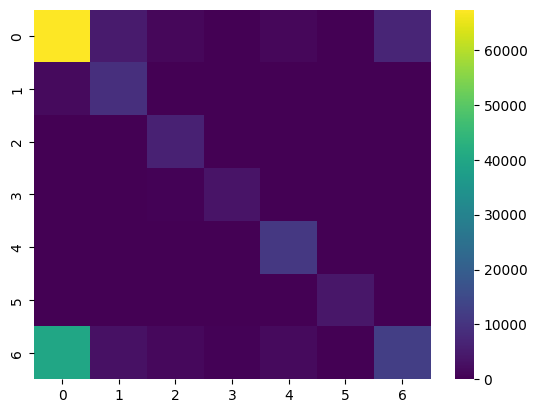

In [ ]:
# Heatmap
sns.heatmap(cmdaug, cmap="viridis")

Test on non-augmented dataset?

In [ ]:
# dftest y_test
y_pred_probs = modelD.predict(dftest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

4599/4599 [==============================] - 10s 2ms/step
Confusion Matrix:
 [[67894  4995  1248   261  1127    58  6787]
 [  413  2384     0     0     0     0    11]
 [   33     0   599    25     0     0     1]
 [    2     0    15   144     4     0     3]
 [    0     0     0    36  2913     0     1]
 [    0     0     0     0     0   150     0]
 [39514  2975  1285   323  1657   132 12148]]


<Axes: >

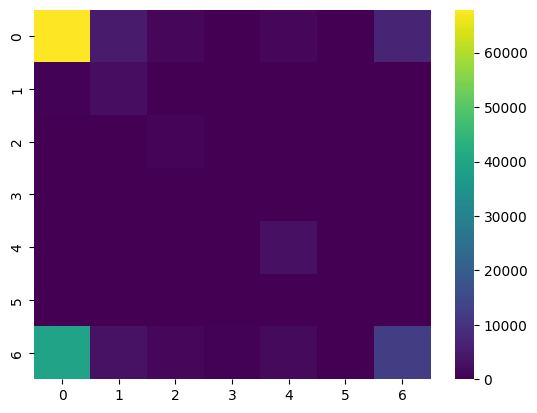

In [ ]:
# Heatmap
sns.heatmap(cm, cmap="viridis")

### Results

As expected, we find better results using the augmented dataset. By examining the heatmaps, we can see that the main diagonal is more distinct. This result is supported by the heatmaps: the model trained with augmented data highlights the diagonal of the map clearly, while the model trained on the non-augmented dataset produces a poor map that primarily focuses on just the first class.


## Conclusion

We approached the problem using three different models:

* Random Forest
* Logistic Regression
* Neural Network

After a thorough analysis, our findings indicate that the Random Forest model performs the best, achieving an accuracy of _65%_. The Neural Network follow closely, reaching a peak accuracy of _63%_, while Logistic Regression lag behind, with an accuracy of _57%_.

The Random Forest model's superior performance can be attributed to its ability to handle complex interactions between features and its robustness to overfitting, especially given the nature of our dataset. The Neural Network, despite its powerful capabilities, may require further tuning and potentially more data to surpass the performance of Random Forest. Logistic Regression, while simpler and more interpretable, struggled with the complexity of the classification task.

Additionally, we obsere that data augmentation significantly improve the performance of all models. This was particularly evident in the heatmaps, where the main diagonal (indicating correct classifications) was much clearer for the augmented dataset. The model trained on augmented data highlighted the diagonal prominently, whereas the non-augmented dataset produced less accurate and more biased maps.

In conclusion, for our specific problem, Random Forest stands out as the most effective model. However, further improvements could potentially be made by exploring more sophisticated neural network architectures or fine-tuning existing models. Data augmentation proved to be a valuable technique, enhancing the overall performance and accuracy of the models.



## References
- RING Software: https://ring.biocomputingup.it/
- PDB: https://www.rcsb.org/
- BioPython: https://biopython.org/